In [1]:
# %matplotlib notebook

In [2]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

In [3]:
retinal = []
with open("C12N.xyz", "r") as file:
    for line in file:
        if line.strip():
            retinal.append([float(x) for x in line.split()[1:]])
retinal = np.array(retinal)

In [4]:
positive_dataset = []
with open("visual_grid_positive_gase_1.txt", 'r') as file:
    for line in file:
        positive_dataset.append([float(x) for x in line.split()])
        
positive_dataset = np.array(positive_dataset)

In [5]:
negative_dataset = []
with open("visual_grid_negative_gase_1.txt", 'r') as file:
    for line in file:
        negative_dataset.append([float(x) for x in line.split()])
        
negative_dataset = np.array(negative_dataset)

In [6]:
dataset = negative_dataset

35.812 6.705 14.371


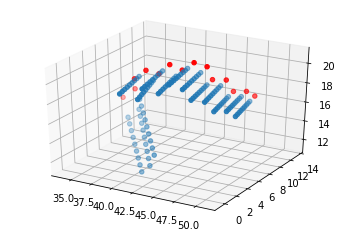

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = dataset[:, 0]
ys = dataset[:, 1]
zs = dataset[:, 2]

print(xs[0], ys[0], zs[0])

ax.scatter(xs, ys, zs)
ax.scatter(*retinal.T, c='r')
plt.show()

In [8]:
def transform2plane(os_0, v1, v2, v3, point):
    return (point - os_0).dot(v1), (point - os_0).dot(v2), (point - os_0).dot(v3)

In [9]:
def create_orto(v1):
    q, _ = np.linalg.qr((np.array([v1, np.array([1, 0, 0]), np.array([0, 1, 0])])).T)
    return q[:, 1], q[:, 2]

In [10]:
def cylinder_symmetry(os_0, v1, point):
    v2, v3 = create_orto(v1)
    x, y, z = transform2plane(os_0, v1, v2, v3, point)
    x_cyl = x
    y_cyl = np.sqrt(y ** 2 + z ** 2)
    return x_cyl, y_cyl

41.78 8.621 19.73


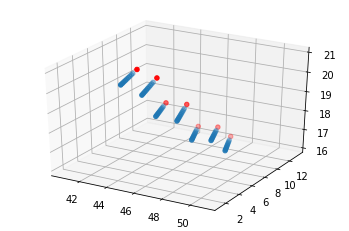

In [11]:
# first = 0
# second = 3
# first = 3
# second = 8
first = 7
second = 14

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = dataset[first * 9 : second * 9, 0]
ys = dataset[first * 9 : second * 9, 1]
zs = dataset[first * 9 : second * 9, 2]

print(xs[0], ys[0], zs[0])

ax.scatter(xs, ys, zs)
ax.scatter(*retinal[first:second].T, c='r')
plt.show()

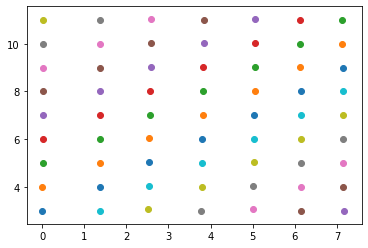

In [12]:
os_0 = retinal[first]
v1 = (retinal[second - 1] - os_0)
v1 = v1 / np.linalg.norm(v1)

points_cyl = []
data = []
plt.figure()
for i in range(first * 9, second * 9):
    point = dataset[i, :3]
    p_new = cylinder_symmetry(os_0, v1, point)
    plt.scatter(p_new[0], p_new[1])

    points_cyl.append(p_new)
    data.append(dataset[i, 3])

    points_cyl.append((p_new[0], -p_new[1]))
    data.append(dataset[i, 3])

points_cyl = np.array(points_cyl)
#     points_cyl.append(p_new) 
#     data.append(positive_dataset[i, 3])
plt.show()


In [13]:
def get_points_cyl(first, second):
    os_0 = retinal[first]
    v1 = (retinal[second - 1] - os_0)
    v1 = v1 / np.linalg.norm(v1)

    points_cyl = []
    data = []
    for i in range(first * 9, second * 9):
        point = dataset[i, :3]
        p_new = cylinder_symmetry(os_0, v1, point)

        points_cyl.append(p_new)
        data.append(dataset[i, 3])

        points_cyl.append((p_new[0], -p_new[1]))
        data.append(dataset[i, 3])

    points_cyl = np.array(points_cyl)
    return points_cyl, data

In [14]:
def interpol(points_cyl, data):
#     interpolation = interpolate.LinearNDInterpolator(points_cyl, data)
#     interpolation = interpolate.SmoothBivariateSpline(*points_cyl.T, data)
    interpolation = interpolate.Rbf(*points_cyl.T, data, function='cubic', smooth=0)
    
    x = np.linspace(points_cyl[:, 0].min(), points_cyl[:, 0].max(), 1000)
    y = np.linspace(points_cyl[:, 1].min(), points_cyl[:, 1].max(), 1000)
    X,Y = meshgrid(x, y)

    Z = interpolation(X, Y) 
#     Z = interpolation(X, Y, grid=False)
    return X, Y, Z

In [15]:
# инерполяция около кольца
first = 0
second = 3
points_cyl, data = get_points_cyl(first, second)
points_cyl_all = points_cyl.copy()
data_all = data.copy()
# X1, Y1, Z1 = interpol(points_cyl, data)

# интерполяция около средней части ретиналя
first = 3
second = 8
points_cyl, data = get_points_cyl(first, second)
points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0) + 1) * [1, 0]])
data_all = np.concatenate([data_all, data])
# X2, Y2, Z2 = interpol(points_cyl, data)

# интерполяция около хвоста ретиналя
first = 7
second = 14
points_cyl, data = get_points_cyl(first, second)
points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0)) * [1, 0]])
data_all = np.concatenate([data_all, data])
# X3, Y3, Z3 = interpol(points_cyl, data)


# X = np.concatenate([X1, X2 + X1.max() - X2.min() + 0.3, X3 + X1.max() + X2.max() - X3.min() + 0.6])
# Y = np.concatenate([Y1, Y2, Y3])
# Z = np.concatenate([Z1, Z2, Z3])

X, Y, Z = interpol(points_cyl_all, data_all)

In [33]:
interpolation = interpolate.Rbf(*points_cyl_all.T, data_all, function='cubic', smooth=0)

print((interpolation(*points_cyl_all.T) - data_all).max())

2.4214372729147726e-09


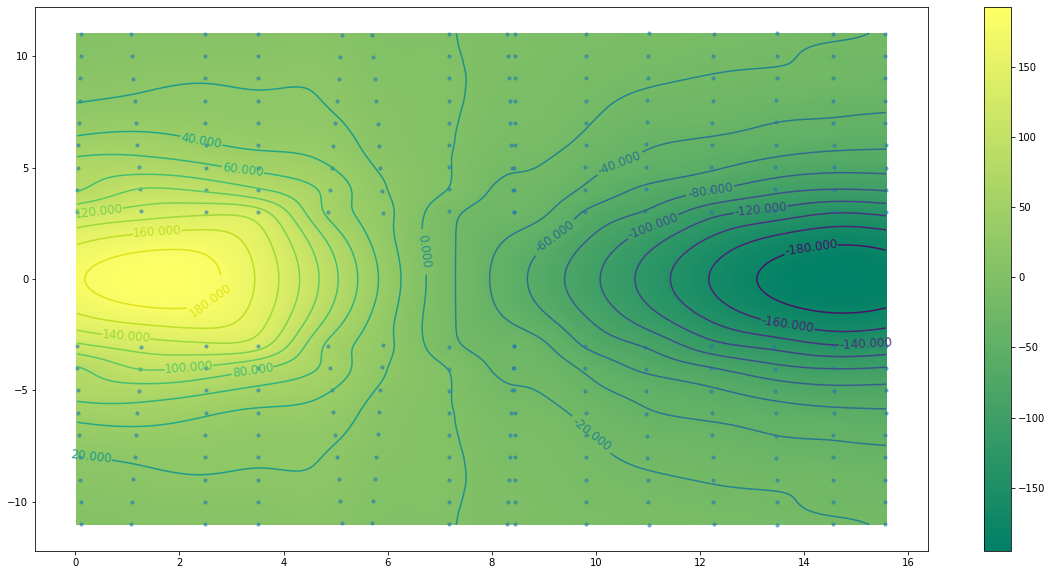

In [17]:
plt.figure(figsize=(20, 10))
im = plt.pcolormesh(X, Y, Z, cmap='summer', )
plt.scatter(*points_cyl_all.T, s=10, alpha=0.5)
CS = plt.contour(X, Y, Z, 20, alpha=1)
plt.clabel(CS, inline=1, fontsize=12)
plt.hlines(0, X[:, 0].min(), X[:, 0].max())
colorbar(im)
show()

In [18]:
# # интерполяция около кольца
# first = 0
# second = 3
# points_cyl, data = get_points_cyl(first, second)
# points_cyl_all = points_cyl.copy()
# X1, Y1, Z1 = interpol(points_cyl, data)

# # интерполяция около средней части ретиналя
# first = 3
# second = 8
# points_cyl, data = get_points_cyl(first, second)
# points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0) + 0.3) * [1, 0]])
# X2, Y2, Z2 = interpol(points_cyl, data)

# # интерполяция около хвоста ретиналя
# first = 7
# second = 14
# points_cyl, data = get_points_cyl(first, second)
# points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0) + 0.3) * [1, 0]])
# X3, Y3, Z3 = interpol(points_cyl, data)


# X = np.concatenate([X1, X2 + X1.max() - X2.min() + 0.3, X3 + X1.max() + X2.max() - X3.min() + 0.6])
# Y = np.concatenate([Y1, Y2, Y3])
# Z = np.concatenate([Z1, Z2, Z3])

# plt.figure(figsize=(20, 10))
# im = plt.pcolormesh(X, Y, Z, cmap='summer', )
# plt.scatter(X1, Y1, s=10, alpha=0.5, color='r')
# plt.scatter(X2 + X1.max() - X2.min() + 0.3, Y2, s=10, alpha=0.5, color='g')
# plt.scatter(X3 + X1.max() + X2.max() - X3.min() + 0.6, Y3, s=10, alpha=0.5, color='b')

# # plt.scatter(*points_cyl_all.T, s=10, alpha=0.5)
# # plt.contour(X, Y, Z, alpha=1)
# plt.hlines(0, X[:, 0].min(), X[:, 0].max())
# colorbar(im)
# show()

In [19]:
# interpolation = interpolate.LinearNDInterpolator(points_cyl, data)
# # interpolation = interpolate.SmoothBivariateSpline(*points_cyl.T, data)

In [20]:
# from numpy import exp,arange
# from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show



# x = np.linspace(points_cyl[:, 0].min(), points_cyl[:, 0].max(), 1000)
# y = np.linspace(points_cyl[:, 1].min(), points_cyl[:, 1].max(), 1000)
# X,Y = meshgrid(x, y) # grid of point

# Z = interpolation(X, Y) # evaluation of the function on the grid
# # Z = interpolation(X, Y, grid=False) # evaluation of the function on the grid

# plt.figure()
# im = plt.pcolormesh(X, Y, Z, cmap='summer')
# plt.scatter(*points_cyl.T, s=10, alpha=0.5)
# plt.contour(X, Y, Z, alpha=1)
# plt.hlines(0, points_cyl[:, 0].min(), points_cyl[:, 0].max())
# # im = imshow(Z,cmap=cm.RdBu) # drawing the function
# # adding the Contour lines with labels
# # cset = contour(Z,arange(-1,1.5,0.2),linewidths=2,cmap=cm.Set2)
# # clabel(cset,inline=True,fmt='%1.1f',fontsize=10)
# colorbar(im) # adding the colobar on the right
# # latex fashion title
# # title('$z=(1-x^2+y^3) e^{-(x^2+y^2)/2}$')
# show()

In [21]:
# from numpy import exp,arange
# from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# first = 0
# second = 3

# os_0 = retinal[first]
# v1 = (retinal[second - 1] - os_0)
# v1 = v1 / np.linalg.norm(v1)

# points_cyl = []
# data = []
# for i in range(first * 9, second * 9):
#     point = positive_dataset[i, :3]
#     p_new = cylinder_symmetry(os_0, v1, point)

#     points_cyl.append(p_new)
#     data.append(positive_dataset[i, 3])

#     points_cyl.append((p_new[0], -p_new[1]))
#     data.append(positive_dataset[i, 3])

# points_cyl = np.array(points_cyl)
# points_cyl_all = points_cyl.copy()

# interpolation = interpolate.LinearNDInterpolator(points_cyl, data)

# x1 = np.linspace(points_cyl[:, 0].min(), points_cyl[:, 0].max(), 1000)
# y1 = np.linspace(points_cyl[:, 1].min(), points_cyl[:, 1].max(), 1000)
# X1,Y1 = meshgrid(x1, y1) # grid of point

# Z1 = interpolation(X1, Y1) # evaluation of the function on the grid

# # fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
# # im = plt.pcolormesh(X, Y, Z, cmap='summer')
# # ax1.scatter(*points_cyl.T, s=10, alpha=0.5)
# # ax1.contour(X, Y, Z, alpha=1)
# # ax1.hlines(0, points_cyl[:, 0].min(), points_cyl[:, 0].max())
# # colorbar(im) # adding the colobar on the right

# first = 3
# second = 8

# os_0 = retinal[first]
# v1 = (retinal[second - 1] - os_0)
# v1 = v1 / np.linalg.norm(v1)

# points_cyl = []
# data = []
# for i in range(first * 9, second * 9):
#     point = positive_dataset[i, :3]
#     p_new = cylinder_symmetry(os_0, v1, point)

#     points_cyl.append(p_new)
#     data.append(positive_dataset[i, 3])

#     points_cyl.append((p_new[0], -p_new[1]))
#     data.append(positive_dataset[i, 3])

# points_cyl = np.array(points_cyl)
# points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0) - points_cyl.min(axis=0) + 0.3) * [1, 0]])

# interpolation = interpolate.LinearNDInterpolator(points_cyl, data)

# x2 = np.linspace(points_cyl[:, 0].min(), points_cyl[:, 0].max(), 1000)
# y2 = np.linspace(points_cyl[:, 1].min(), points_cyl[:, 1].max(), 1000)
# X2,Y2 = meshgrid(x2, y2) # grid of point

# Z2 = interpolation(X2, Y2) # evaluation of the function on the grid

# # im = plt.pcolormesh(X, Y, Z, cmap='summer')
# # plt.scatter(*points_cyl.T, s=10, alpha=0.5)
# # ax2.contour(X, Y, Z, alpha=1)
# # ax2.hlines(0, points_cyl[:, 0].min(), points_cyl[:, 0].max())
# # colorbar(im) # adding the colobar on the right

# first = 7
# second = 14

# os_0 = retinal[first]
# v1 = (retinal[second - 1] - os_0)
# v1 = v1 / np.linalg.norm(v1)

# points_cyl = []
# data = []
# for i in range(first * 9, second * 9):
#     point = positive_dataset[i, :3]
#     p_new = cylinder_symmetry(os_0, v1, point)

#     points_cyl.append(p_new)
#     data.append(positive_dataset[i, 3])

#     points_cyl.append((p_new[0], -p_new[1]))
#     data.append(positive_dataset[i, 3])

# points_cyl = np.array(points_cyl)
# points_cyl_all = np.concatenate([points_cyl_all, points_cyl + (points_cyl_all.max(axis=0) - points_cyl.min(axis=0) + 0.3) * [1, 0]])

# interpolation = interpolate.LinearNDInterpolator(points_cyl, data)

# x3 = np.linspace(points_cyl[:, 0].min(), points_cyl[:, 0].max(), 1000)
# y3 = np.linspace(points_cyl[:, 1].min(), points_cyl[:, 1].max(), 1000)
# X3,Y3 = meshgrid(x3, y3) # grid of point

# Z3 = interpolation(X3, Y3) # evaluation of the function on the grid

# X = np.concatenate([X1, X2 + X1.max() - X2.min() + 0.3, X3 + X1.max() + X2.max() - X3.min() + 0.6])
# Y = np.concatenate([Y1, Y2, Y3])
# Z = np.concatenate([Z1, Z2, Z3])

# plt.figure(figsize=(20, 10))
# im = plt.pcolormesh(X, Y, Z, cmap='summer')
# plt.scatter(*points_cyl_all.T, s=10, alpha=0.5)
# plt.contour(X, Y, Z, alpha=1)
# plt.hlines(0, X[:, 0].min(), X[:, 0].max())
# colorbar(im) # adding the colobar on the right
# show()
